In [115]:
#Libraries
import pandas as pd
import numpy as np
from pathlib import Path #this library minimizes issues when using paths in Mac
import os
#pip install dataprep --user
from dataprep.eda import create_report
import re
import seaborn as sns
import streamlit as st
import datetime

import matplotlib.pyplot as plt

from warnings import filterwarnings
filterwarnings('ignore')

from scipy.stats.mstats import winsorize
import scipy.stats as stats

import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse

from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error,explained_variance_score
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import (train_test_split,GridSearchCV, cross_val_score, cross_val_predict, StratifiedKFold, learning_curve)

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns # data visualization library  
import os
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from yellowbrick.cluster import KElbowVisualizer
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from sklearn.decomposition import PCA

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LassoCV

import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

In [116]:
#pip freeze > requirements.txt

In [117]:
#Seaborn Context
sns.set_theme(style='whitegrid', context='talk', palette='deep')
#plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1));
#sns.set_palette(['#62C370', '#FFD166', '#EF476F'])# Plot
#plt.figure(figsize=(9, 5)) 

In [118]:
#List of Folders
prod_folder = Path("data/Value_of_Production_E_All_Data")
pop_folder = Path("data/Population_E_All_Data")

In [119]:
def clean_fao_df(df,element, drop_columns,value_column):
    #remove flags
    df = df[df.columns.drop(list(df.filter(regex='.*?F')))]
    #filter by element
    df = df[df["Element"]==element]
    #drop columns
    df = df[df.columns.drop(drop_columns)]
    #wide_to_long by year
    df=pd.wide_to_long(df, stubnames='Y', i=['Area', 'Item'], j='Year').reset_index()
    df.rename(columns = {'Y':value_column}, inplace = True)
    return df

In [120]:
prod_df = pd.read_csv(prod_folder /"Value_of_Production_E_All_Data.csv", encoding = 'unicode_escape')
prod_df.head()

Area Code Area Code (M49)         Area  Item Code Item Code (CPC)  \
0          2            '004  Afghanistan        221          '01371   
1          2            '004  Afghanistan        221          '01371   
2          2            '004  Afghanistan        221          '01371   
3          2            '004  Afghanistan        711          '01654   
4          2            '004  Afghanistan        515          '01341   

                                                Item  Element Code  \
0                                  Almonds, in shell           152   
1                                  Almonds, in shell            56   
2                                  Almonds, in shell            55   
3  Anise, badian, coriander, cumin, caraway, fenn...           152   
4                                             Apples           152   

                                             Element         Unit   Y1961  \
0  Gross Production Value (constant 2014-2016 tho...  1000 Int. $     NaN   
1      Gross Production Value (current thousand SLC)     1000 SLC     NaN   
2  Gross Production Value (constant 2014-2016 tho...     1000 SLC     NaN   
3  Gross Production Value (constant 2014-2016 tho...  1000 Int. $     NaN   
4  Gross Production Value (constant 2014-2016 tho...  1000 Int. $  7127.0   

   ...      Y2016  Y2016F      Y2017  Y2017F      Y2018  Y2018F      Y2019  \
0  ...   166057.0       E   137986.0       E   173995.0       E   193168.0   
1  ...  6539411.0       E  5213293.0       E  6239642.0       E  6707803.0   
2  ...  7004306.0       E  5820251.0       E  7339134.0       E  8147840.0   
3  ...    37675.0       E    41176.0       E    39326.0       E    39392.0   
4  ...    66506.0       E    80449.0       E   102515.0       E   118153.0   

   Y2019F      Y2020  Y2020F  
0       E   198739.0       E  
1       E  7160695.0       E  
2       E  8382859.0       E  
3       E    39965.0       E  
4       E   127845.0       E  

[5 rows x 129 columns]

In [121]:
drop_columns = ["Area Code (M49)", "Area Code", "Item Code","Item Code (CPC)", "Element", "Element Code", "Unit"]
prod_df = clean_fao_df(prod_df, 'Gross Production Value (constant 2014-2016 thousand I$)', drop_columns, 'Total_Prod' )

In [42]:
#Chose 2019 as 2020 could be impacted by Covid
#https://www.nature.com/articles/s41599-022-01080-0
#The study concluded that interruptions in agricultural food supply as a result of the pandemic impacted supply and demand shocks with negative impacts on all the four pillars of food security.
prod19_df=prod_df[prod_df["Year"]==2019]
prod19_df = prod19_df[prod19_df.columns.drop(['Year'])]

In [44]:
pop_df = pd.read_csv(pop_folder /"Population_E_All_Data_NOFLAG.csv", encoding = 'unicode_escape')

In [45]:
drop_columns = ["Area Code (M49)", "Area Code", "Item Code", "Element", "Element Code", "Unit"]
pop_df = clean_fao_df(pop_df, 'Total Population - Both sexes', drop_columns, 'Total_Population' )
pop19_df=pop_df[pop_df["Year"]==2019]
pop19_df = pop19_df[pop19_df.columns.drop(['Item', 'Year'])]
pop19_df.head()

Area  Total_Population
69      Afghanistan         37769.499
220         Albania          2873.883
371         Algeria         42705.368
522  American Samoa            47.321
673         Andorra            76.343

In [46]:
prod19_df=prod19_df.merge(pop19_df, how='left', on='Area') 

In [47]:
prod19_df['Prod_Capita']=prod19_df['Total_Prod']/prod19_df['Total_Population']
prod19_df = prod19_df[prod19_df.columns.drop(['Total_Prod', 'Total_Population'])]

In [48]:
prod19_df.head()

Area                                               Item  Prod_Capita
0  Afghanistan                                  Almonds, in shell     5.114391
1  Afghanistan  Anise, badian, coriander, cumin, caraway, fenn...     1.042958
2  Afghanistan                                             Apples     3.128265
3  Afghanistan                                           Apricots     2.805306
4  Afghanistan                                             Barley     0.637446

In [49]:
prod19_df=prod19_df.pivot(index='Area', columns='Item', values='Prod_Capita')

In [50]:
prod19_df=prod19_df.reset_index(level=0)

In [51]:
#Noticed that there are Areas that are not countries, but groups of them ("World", "Americas", etc.)
#Downloaded the groups file to remove them at once
pop_group_df = pd.read_csv(pop_folder /"Population_E_All_Area_Groups_NOFLAG.csv", encoding = 'unicode_escape')

In [52]:
prod19_df = prod19_df[~prod19_df['Area'].isin(pop_group_df['Area'].unique())] 

In [53]:
prod19_df.head()

Item                 Area  Abaca, manila hemp, raw  Agave fibres, raw, n.e.c.  \
0             Afghanistan                      NaN                        NaN   
2                 Albania                      NaN                        NaN   
3                 Algeria                      NaN                        NaN   
5                  Angola                      NaN                        NaN   
6     Antigua and Barbuda                      NaN                        NaN   

Item  Agriculture  Almonds, in shell  \
0      174.078401           5.114391   
2      736.821228                NaN   
3      364.737754           8.573185   
5      190.689824                NaN   
6       92.230533                NaN   

Item  Anise, badian, coriander, cumin, caraway, fennel and juniper berries, raw  \
0                                              1.042958                           
2                                                   NaN                           
3                                                   NaN                           
5                                                   NaN                           
6                                                   NaN                           

Item     Apples  Apricots  Areca nuts  Artichokes  ...  \
0      3.128265  2.805306         NaN         NaN  ...   
2     17.398412  1.389409         NaN         NaN  ...   
3      6.176483  4.012376         NaN    1.941981  ...   
5           NaN       NaN         NaN         NaN  ...   
6           NaN       NaN         NaN         NaN  ...   

Item  Unmanufactured tobacco  Vanilla, raw  Vegetables Primary  \
0                        NaN           NaN           12.133944   
2                   1.093294           NaN          151.655095   
3                   0.795263           NaN           73.969390   
5                   0.201152           NaN            6.316054   
6                        NaN           NaN            6.622013   

Item  Vegetables and Fruit Primary   Vetches  Walnuts, in shell  Watermelons  \
0                        62.010804       NaN            1.22771     5.202902   
2                       307.200398  0.251924                NaN    20.965711   
3                       159.457167  0.000679                NaN    11.989523   
5                        63.896623       NaN                NaN          NaN   
6                        64.928298       NaN                NaN          NaN   

Item      Wheat      Yams  Yautia  
0     30.662361       NaN     NaN  
2     19.218945       NaN     NaN  
3     21.499944       NaN     NaN  
5      0.021667       NaN     NaN  
6           NaN  0.390807     NaN  

[5 rows x 200 columns]

In [54]:
cols=['Area','Cereals, Total','Fruit Primary',
                                    'Meat indigenous, total','Milk, Total',
                                    'Non Food','Roots and Tubers, Total',
                                    'Sugar Crops Primary','Vegetables Primary']
prod19_df=prod19_df[cols]

In [57]:
print("There are",prod19_df.shape[1]-1, "products and", prod19_df.shape[0], "countries.\n")
print("The Products with most null values are:")
print(prod19_df.isnull().sum().sort_values(ascending=False).head(5).to_string())


There are 8 products and 195 countries.

The Products with most null values are:
Item
Sugar Crops Primary    61
Non Food               20
Cereals, Total         15
Milk, Total             8
Fruit Primary           1


In [58]:
#Drop countries with more than 50% of values null
prod19_df.dropna(thresh=(prod19_df.shape[1]+1)/2, inplace=True)

In [59]:
#Check: 
#print(prod19_df.isna().sum(axis=1).sort_values(ascending=False).head(20).to_string())

In [60]:
prod19_df.describe().T

count        mean         std       min        25%  \
Item                                                                          
Cereals, Total           180.0   77.019542   97.848773  0.002793  11.489062   
Fruit Primary            194.0   60.153664   68.857705  0.000341  15.475891   
Meat indigenous, total   195.0  116.362872  147.878527  1.027024  32.067347   
Milk, Total              187.0   67.643678  154.882531  0.003335   6.713263   
Non Food                 175.0   11.186390   23.153876  0.011473   1.034110   
Roots and Tubers, Total  194.0   28.114953   51.481350  0.000511   5.653638   
Sugar Crops Primary      134.0   16.066358   33.464111  0.001862   1.079345   
Vegetables Primary       194.0   31.180197   33.792774  0.323232   9.480679   

                               50%         75%          max  
Item                                                         
Cereals, Total           39.850869   94.290468   415.269755  
Fruit Primary            38.262886   77.354095   498.016533  
Meat indigenous, total   72.294603  138.024087  1143.134127  
Milk, Total              24.719916   89.946427  1828.248606  
Non Food                  4.444478   10.504840   230.533608  
Roots and Tubers, Total  14.179483   30.016120   581.988548  
Sugar Crops Primary       5.499088   14.819981   220.159147  
Vegetables Primary       17.115678   40.076852   176.513701

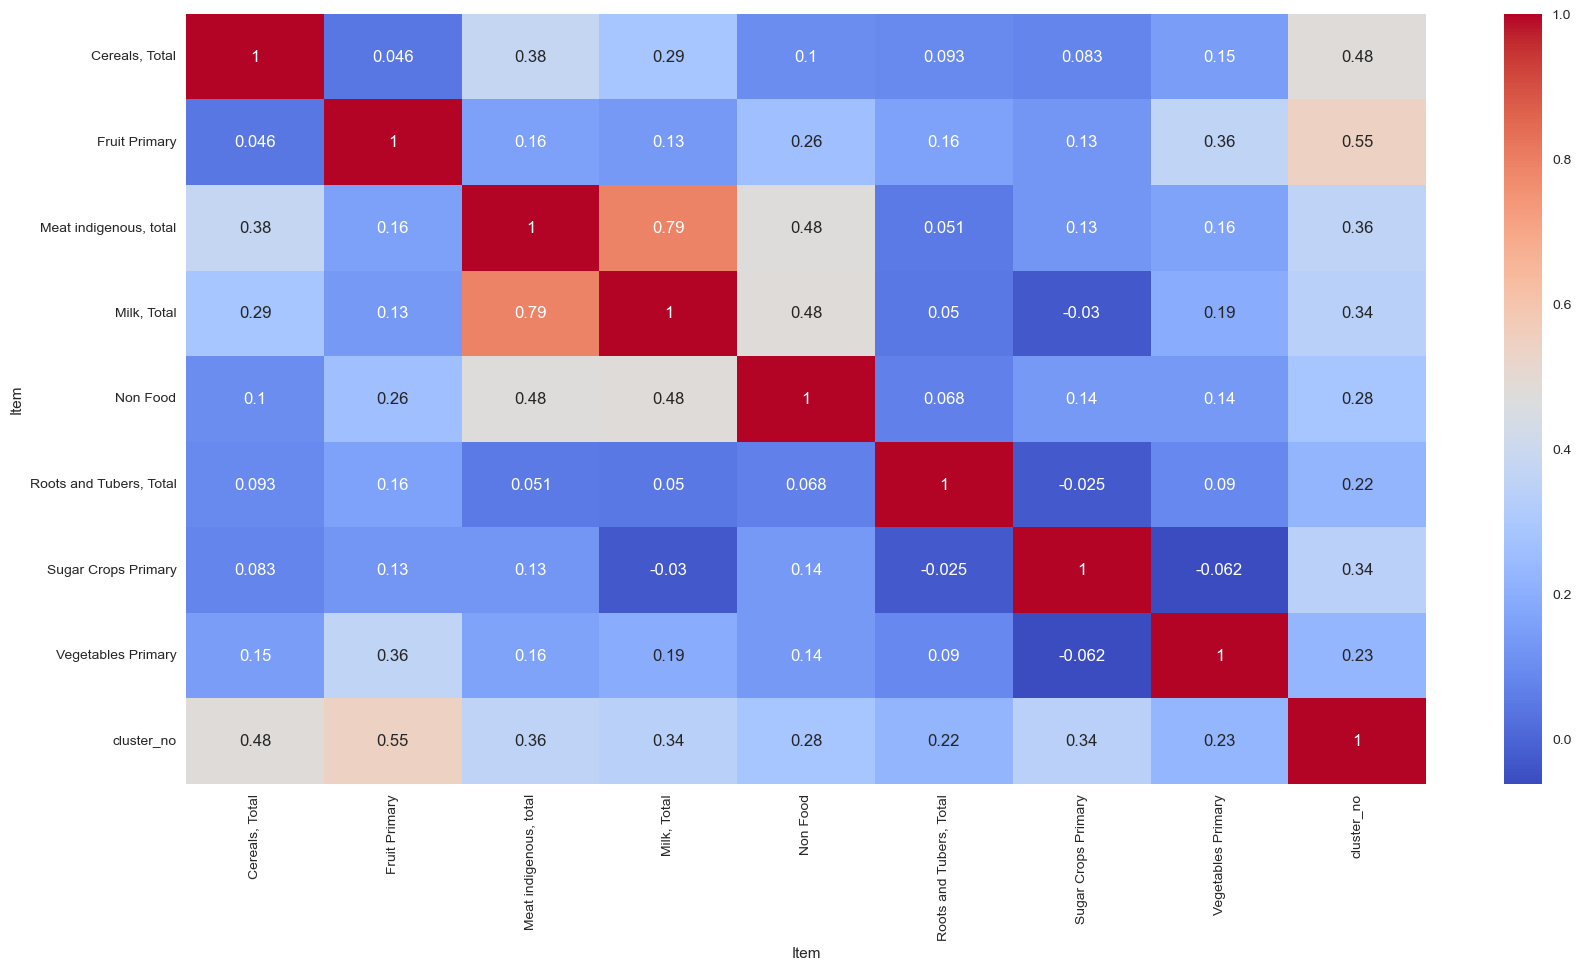

In [102]:
#plotting the correlation matrix
%matplotlib inline
plt.figure(figsize = (20,10))
sns.heatmap(prod19_df.corr(),annot = True, cmap='coolwarm')
plt.show()

In [62]:
#featurewiz does not work for clustering or unsupervised problems
#pip install featurewiz --user

In [63]:
prod19_df.fillna(0, inplace=True)

In [64]:
prod19_df.set_index('Area', inplace=True)
prod19_df.head()

Item                 Cereals, Total  Fruit Primary  Meat indigenous, total  \
Area                                                                         
Afghanistan               36.263282      49.876860               30.440250   
Albania                   49.112995     155.545650               96.876247   
Algeria                   29.452386      85.487778               64.256817   
Angola                    18.371780      57.580569               30.352553   
Antigua and Barbuda        0.108558      58.306284                4.505140   

Item                 Milk, Total   Non Food  Roots and Tubers, Total  \
Area                                                                   
Afghanistan            24.313719   2.170455                 6.103549   
Albania               167.844690  17.509759                22.699254   
Algeria                35.373773   3.959409                29.420493   
Angola                  2.807108   1.636325                54.670691   
Antigua and Barbuda    13.808526   0.000000                 1.107287   

Item                 Sugar Crops Primary  Vegetables Primary  
Area                                                          
Afghanistan                     0.054991           12.133944  
Albania                         0.503500          151.655095  
Algeria                         0.000000           73.969390  
Angola                          1.040472            6.316054  
Antigua and Barbuda             0.000000            6.622013

In [67]:
#https://www.kaggle.com/code/emilytries/clustering-and-feature-selection
def outlier_thresholds(dataframe, variable):
    quartile1 = dataframe[variable].quantile(0.01)
    quartile3 = dataframe[variable].quantile(0.99)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit


def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit
    
for col in prod19_df.columns:
    replace_with_thresholds(prod19_df, col)

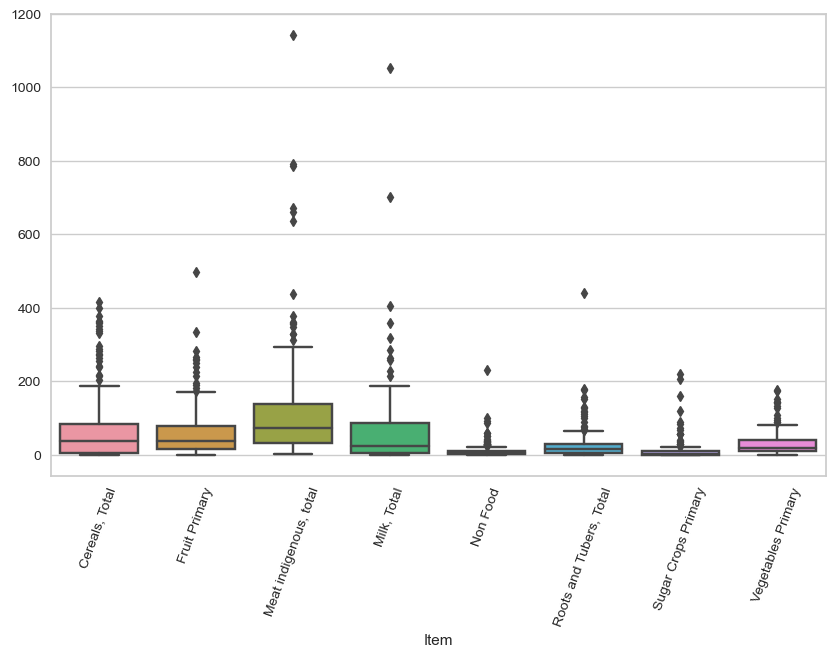

In [71]:
plt.figure(figsize=(10,6))
sns.boxplot(data=prod19_df)
plt.xticks(rotation=70)
plt.show()

In [72]:
# Min Max Scaler
names = prod19_df.columns
indexes = prod19_df.index
sc = MinMaxScaler((0, 1))
df = sc.fit_transform(prod19_df)
data_scaled = pd.DataFrame(df, columns=names, index=indexes)
data_scaled.head()

Item                 Cereals, Total  Fruit Primary  Meat indigenous, total  \
Area                                                                         
Afghanistan                0.087325       0.100151                0.025753   
Albania                    0.118268       0.312330                0.083923   
Algeria                    0.070924       0.171657                0.055362   
Angola                     0.044241       0.115620                0.025677   
Antigua and Barbuda        0.000261       0.117077                0.003045   

Item                 Milk, Total  Non Food  Roots and Tubers, Total  \
Area                                                                  
Afghanistan             0.023100  0.009416                 0.013908   
Albania                 0.159464  0.075962                 0.051724   
Algeria                 0.033608  0.017177                 0.067039   
Angola                  0.002667  0.007099                 0.124576   
Antigua and Barbuda     0.013119  0.000000                 0.002523   

Item                 Sugar Crops Primary  Vegetables Primary  
Area                                                          
Afghanistan                     0.000250            0.068742  
Albania                         0.002287            0.859169  
Algeria                         0.000000            0.419057  
Angola                          0.004726            0.035782  
Antigua and Barbuda             0.000000            0.037516

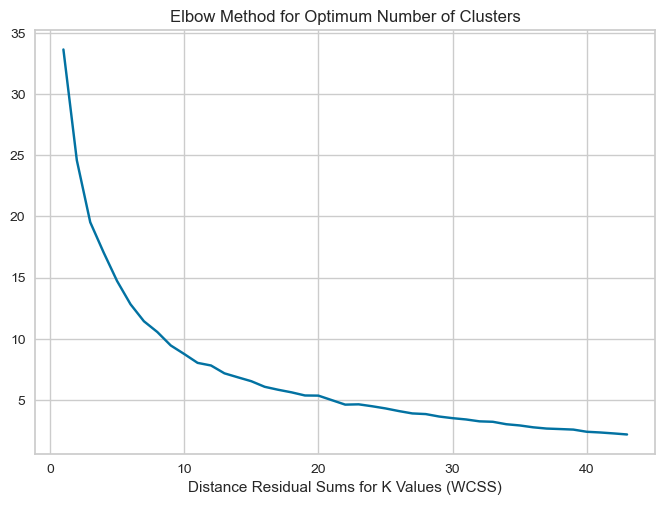

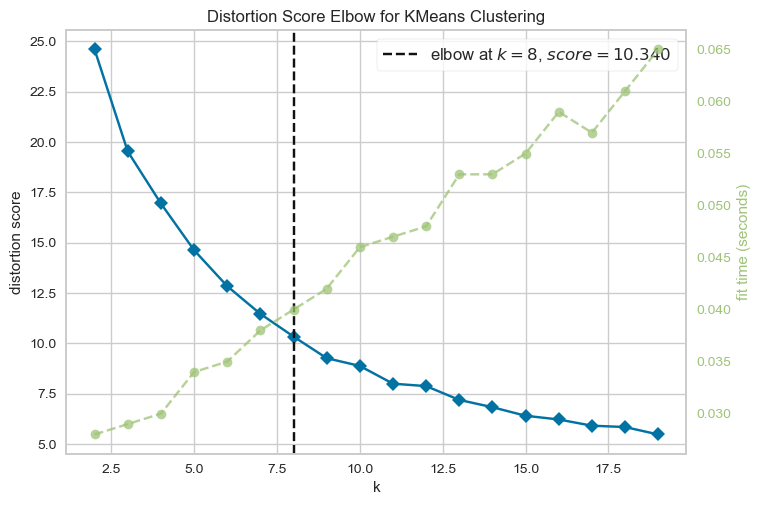

In [74]:
# KMeans Clustering
#https://www.scikit-yb.org/en/latest/api/cluster/elbow.html
kmeans = KMeans()
ssd = []
K = range(1, 44)

for k in K:
    kmeans = KMeans(n_clusters=k).fit(data_scaled)
    ssd.append(kmeans.inertia_)

ssd

plt.plot(K, ssd, "bx-")
plt.xlabel("Distance Residual Sums for K Values (WCSS)")
plt.title("Elbow Method for Optimum Number of Clusters")
plt.show()

kmeans = KMeans()
fig = KElbowVisualizer(kmeans, k=(2, 20))
fig.fit(df)
fig.show();

In [89]:
kmeans = KMeans(n_clusters=8).fit(data_scaled)
clusters = kmeans.labels_

pd.DataFrame({"Customers": prod19_df.index, "Clusters": clusters})
prod19_df["cluster_no"] = clusters
prod19_df.head()

Item                 Cereals, Total  Fruit Primary  Meat indigenous, total  \
Area                                                                         
Afghanistan               36.263282      49.876860               30.440250   
Albania                   49.112995     155.545650               96.876247   
Algeria                   29.452386      85.487778               64.256817   
Angola                    18.371780      57.580569               30.352553   
Antigua and Barbuda        0.108558      58.306284                4.505140   

Item                 Milk, Total   Non Food  Roots and Tubers, Total  \
Area                                                                   
Afghanistan            24.313719   2.170455                 6.103549   
Albania               167.844690  17.509759                22.699254   
Algeria                35.373773   3.959409                29.420493   
Angola                  2.807108   1.636325                54.670691   
Antigua and Barbuda    13.808526   0.000000                 1.107287   

Item                 Sugar Crops Primary  Vegetables Primary  cluster_no  
Area                                                                      
Afghanistan                     0.054991           12.133944           0  
Albania                         0.503500          151.655095           1  
Algeria                         0.000000           73.969390           2  
Angola                          1.040472            6.316054           0  
Antigua and Barbuda             0.000000            6.622013           0

In [90]:
#prod19_df["cluster_no"] = prod19_df["cluster_no"] + 1
prod19_df.groupby("cluster_no").agg({"cluster_no": "count"})

Item        cluster_no
cluster_no            
0                  102
1                    9
2                   30
3                   18
4                   21
5                    4
6                   10
7                    1

In [91]:
prod19_df.groupby("cluster_no").agg(np.mean)

Item        Cereals, Total  Fruit Primary  Meat indigenous, total  \
cluster_no                                                          
0                21.107060      30.942020               68.294676   
1                71.732759     124.587464              152.576201   
2                41.743218      76.476317              102.131619   
3               322.461685      63.681402              282.056997   
4               157.889515      34.657660              161.241412   
5                48.389479      78.173926              165.396330   
6                45.548248     265.332650              101.975360   
7                43.675442     258.049854             1143.134127   

Item        Milk, Total    Non Food  Roots and Tubers, Total  \
cluster_no                                                     
0             28.415933    6.485602                20.072659   
1            113.349199   12.281308                27.575177   
2             49.530584    7.266036                26.572359   
3            137.760861   10.878467                36.639324   
4            114.539492   16.304739                37.058056   
5             22.814657   10.874977                 9.059685   
6             44.035027   15.532849                71.768099   
7           1052.555603  230.506524                26.762470   

Item        Sugar Crops Primary  Vegetables Primary  
cluster_no                                           
0                      4.935647           12.526887  
1                      4.397956          143.832514  
2                      6.256522           59.996160  
3                     15.975382           31.763387  
4                     12.523212           31.517677  
5                    176.177033           12.598229  
6                     16.692627           32.201982  
7                      0.000000           70.813388

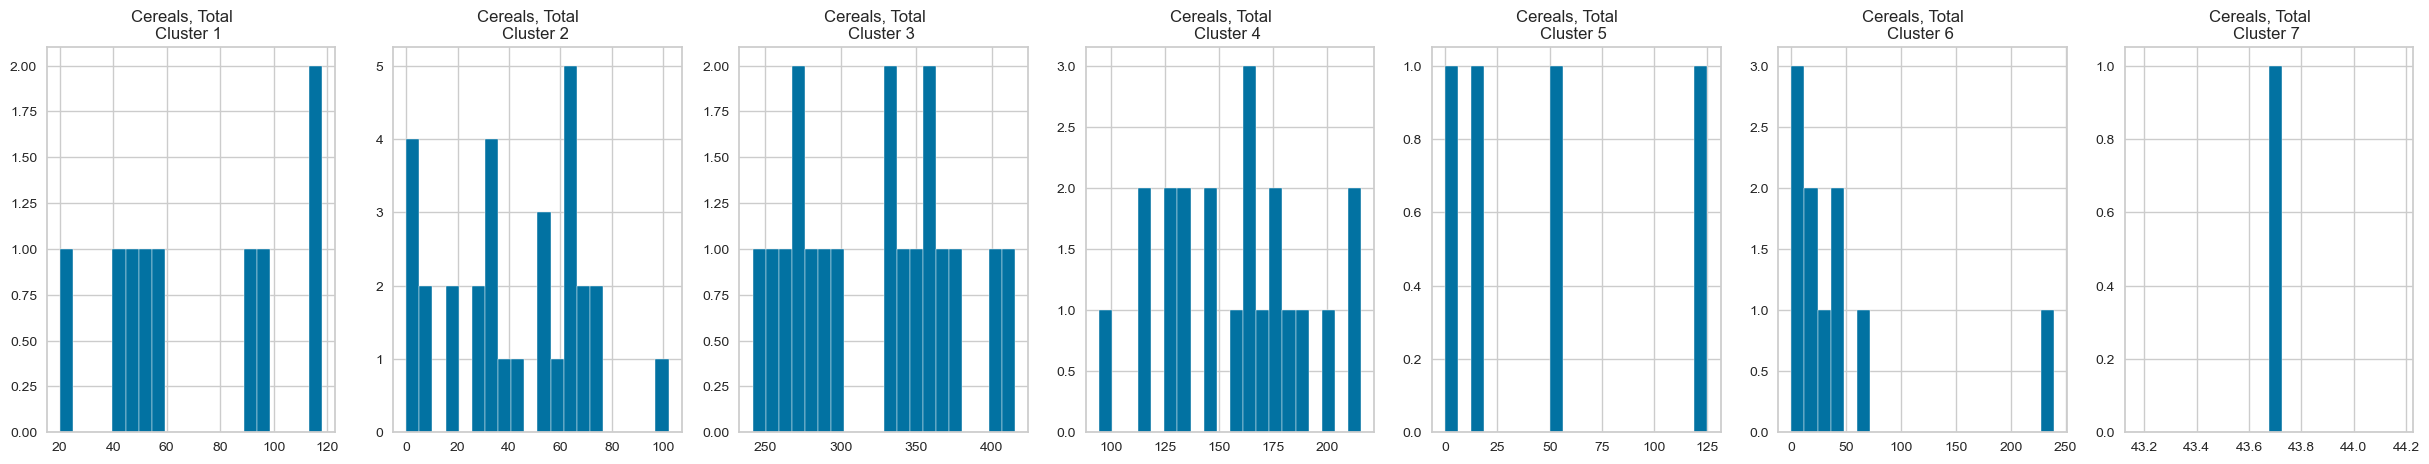

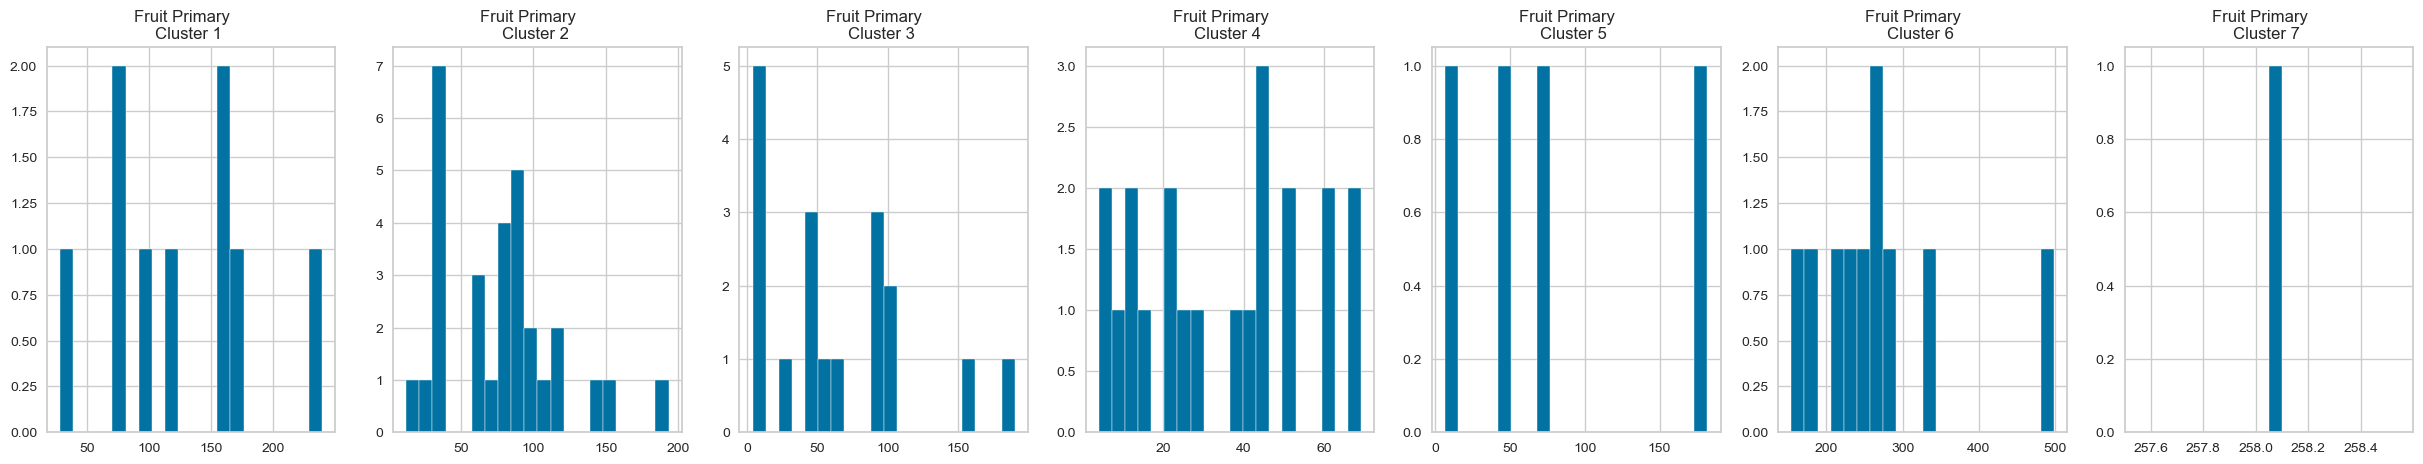

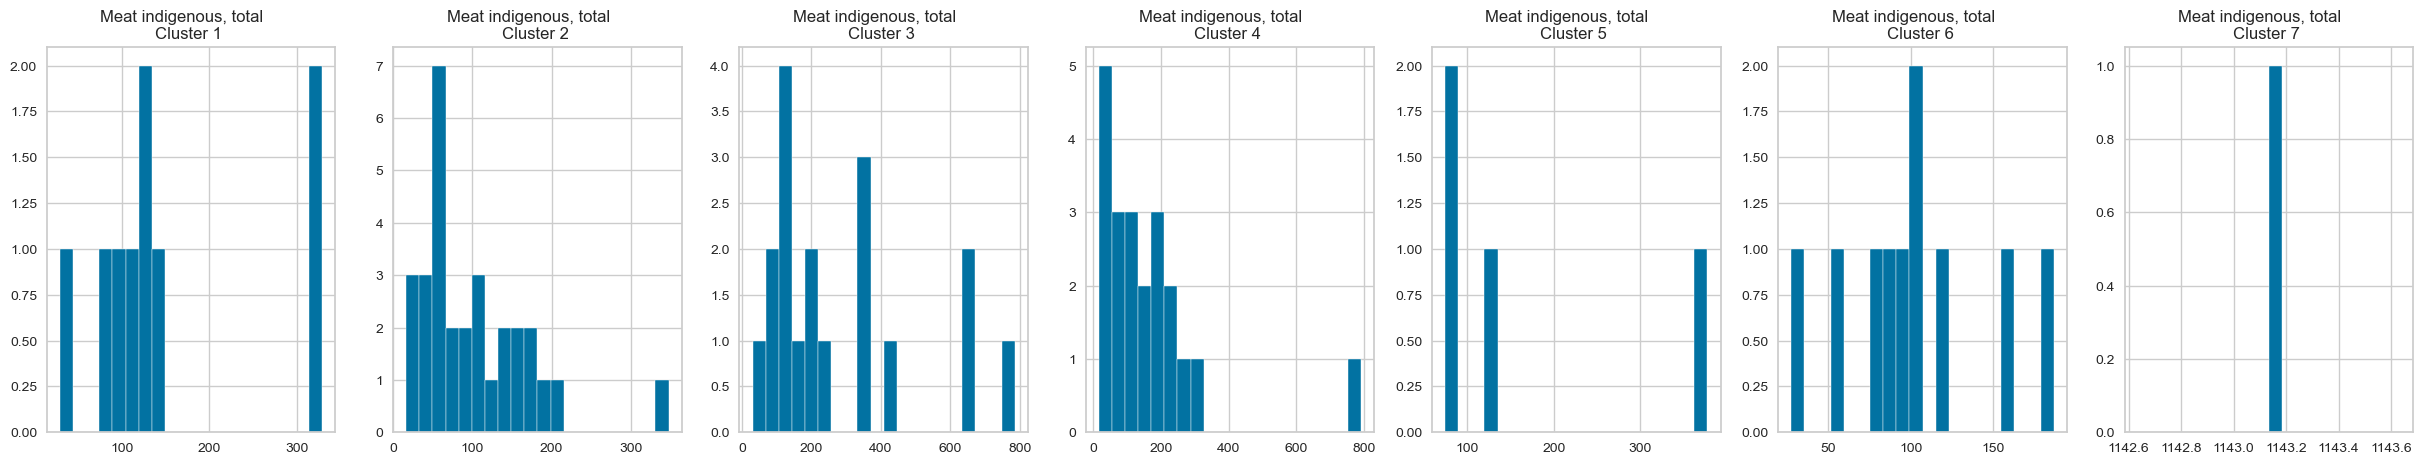

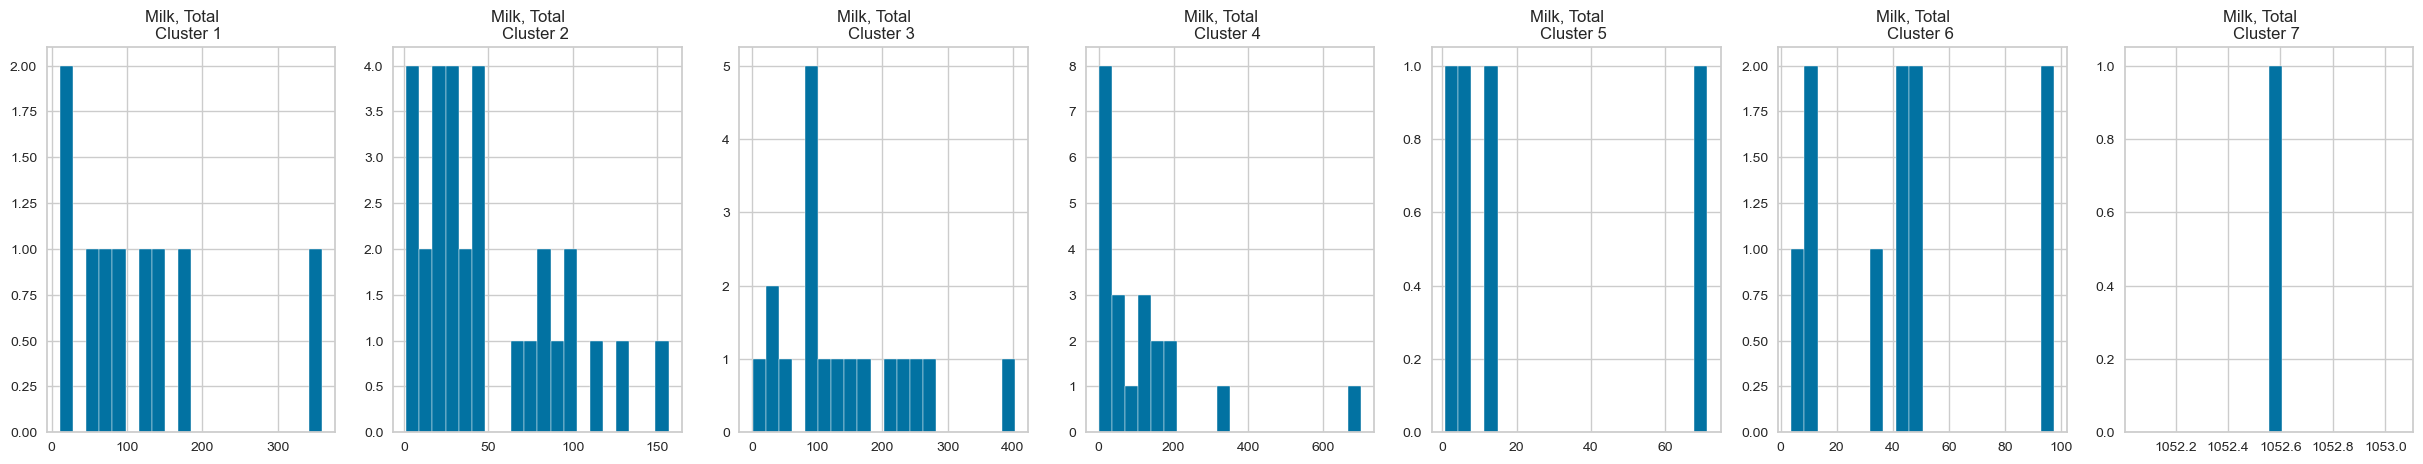

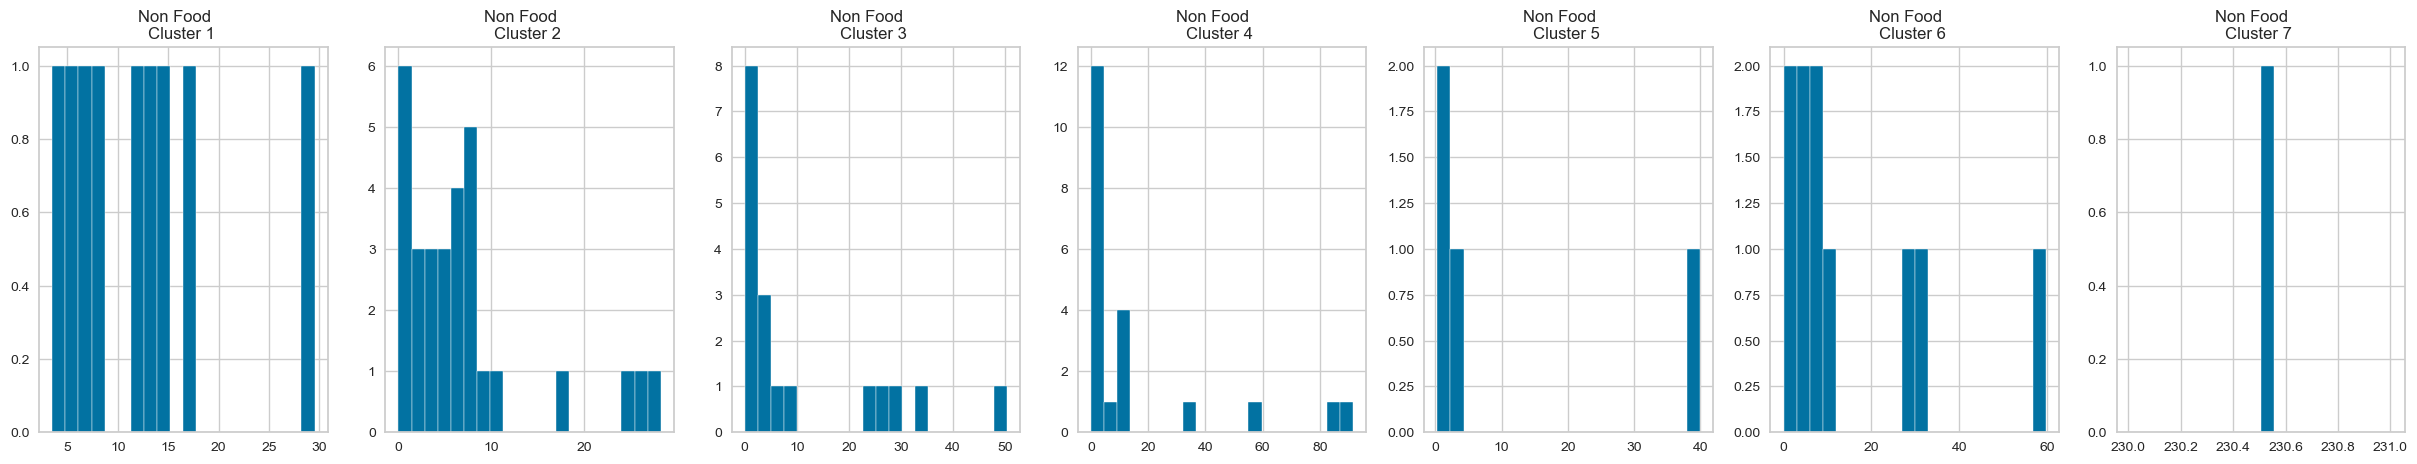

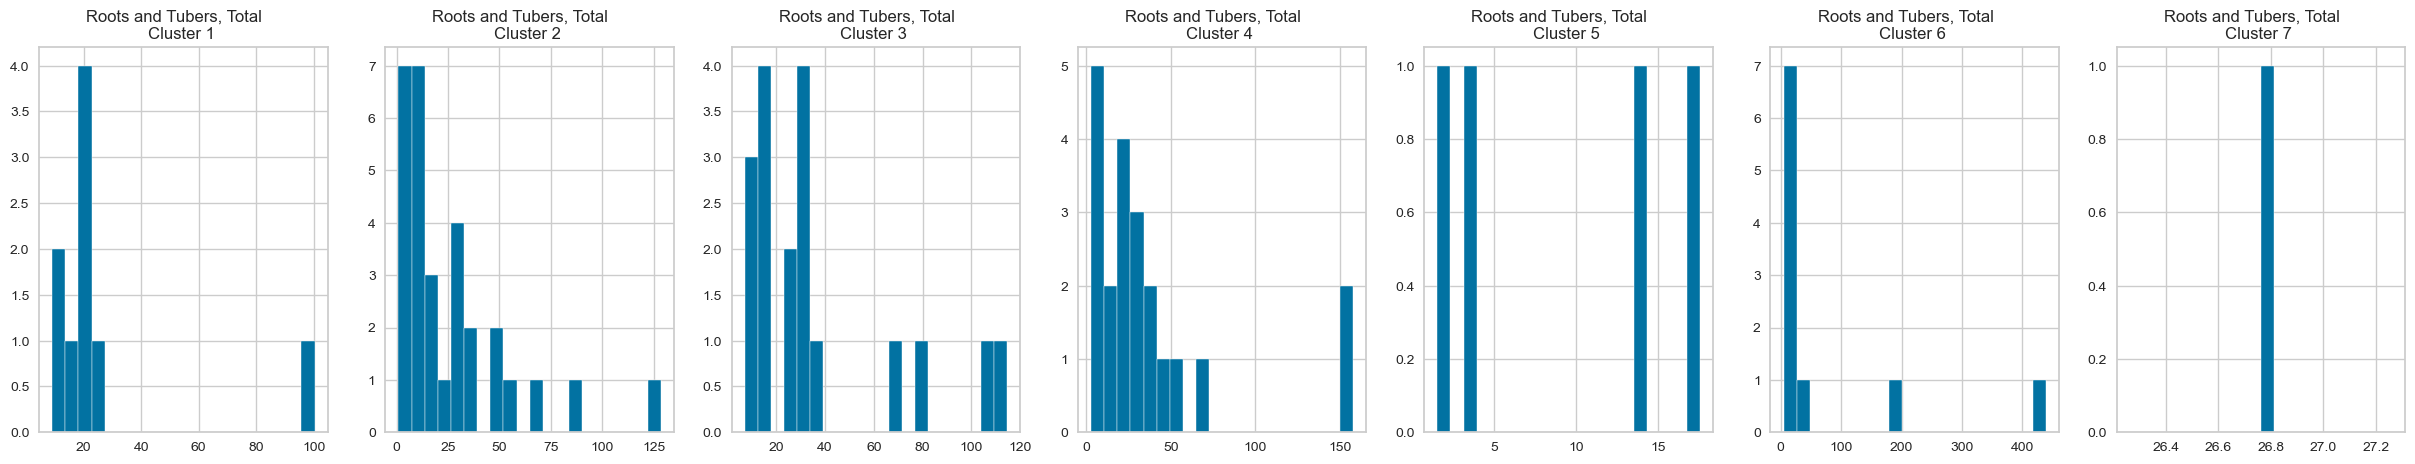

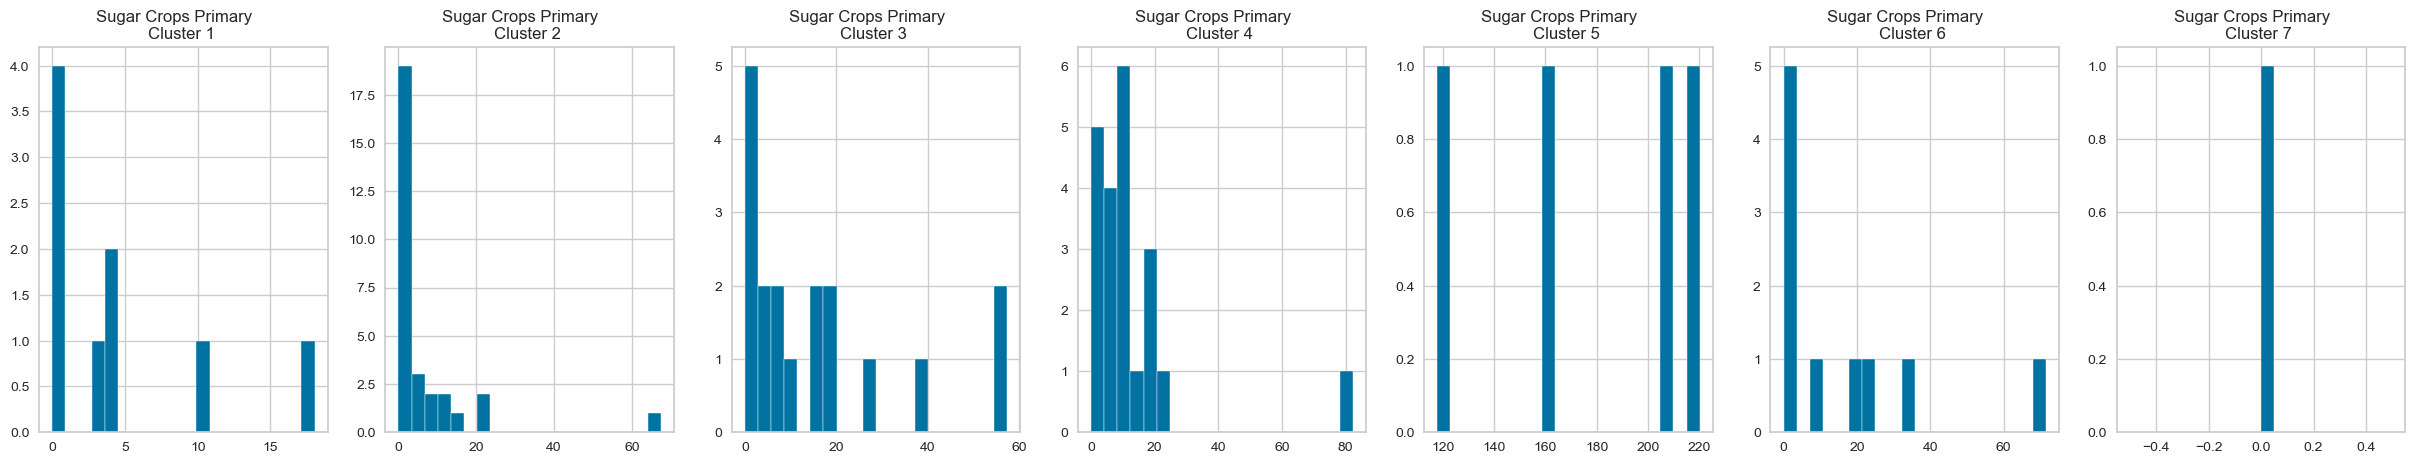

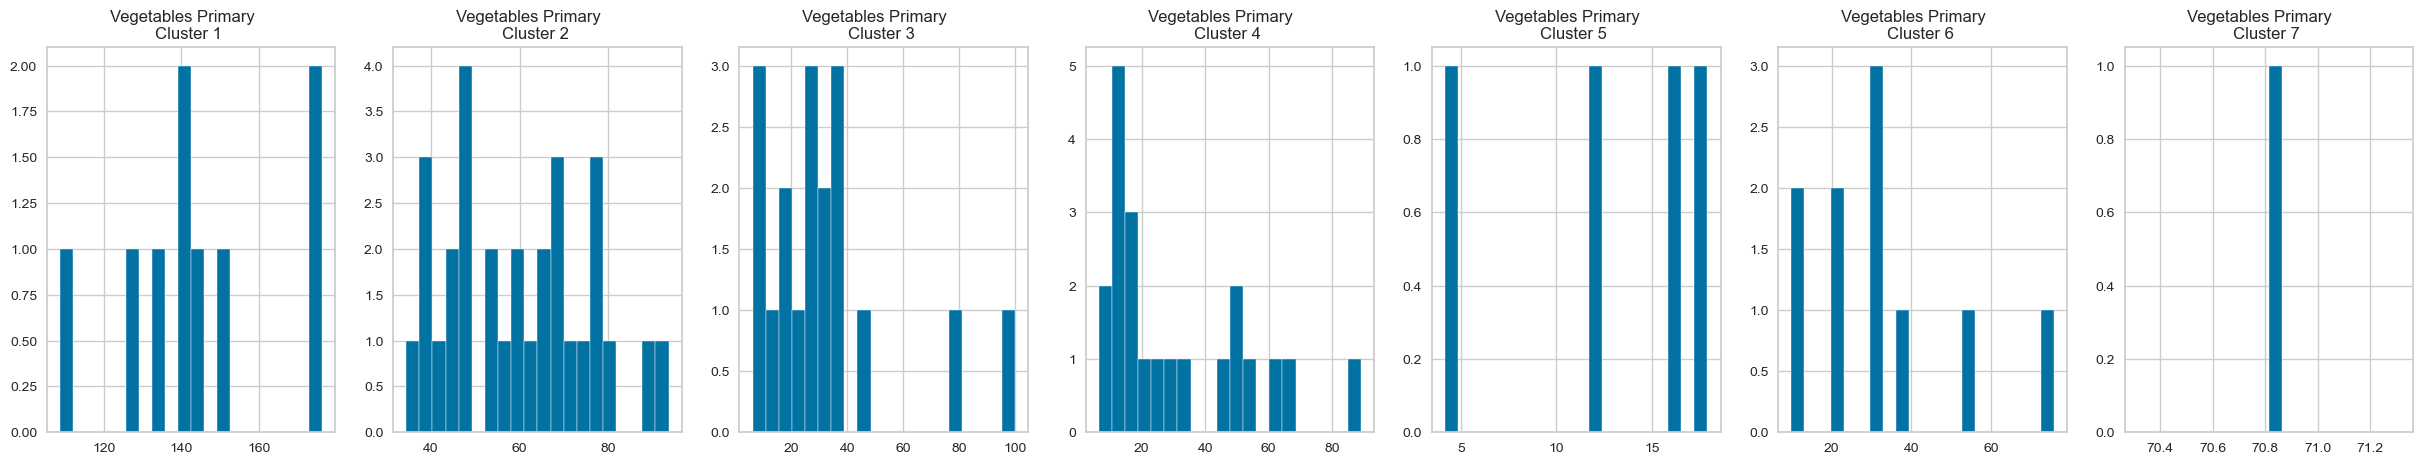

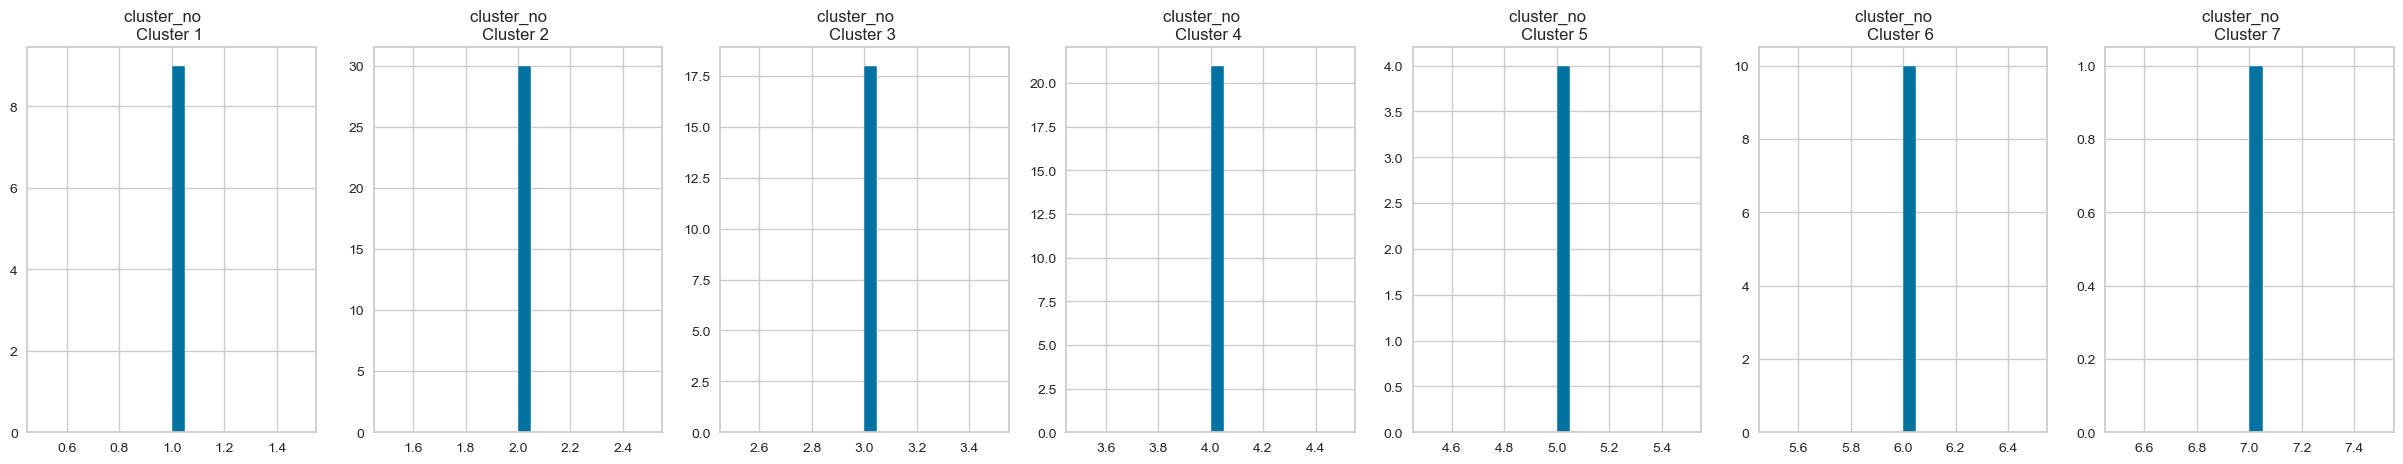

In [92]:
for i in prod19_df.columns:
  plt.figure(figsize = (35, 5))
  for j in range(1,8):
    plt.subplot(1,8,j+1)
    cluster = prod19_df[prod19_df['cluster_no'] == j]
    cluster[i].hist(bins = 20)
    plt.title('{}    \nCluster {} '.format(i,j))
  
  plt.show()

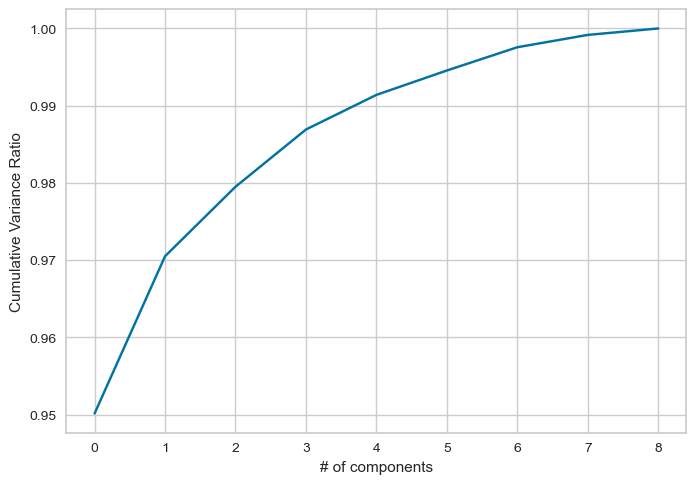

In [93]:
pca = PCA().fit(data_scaled)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("# of components")
plt.ylabel("Cumulative Variance Ratio")
plt.show()

In [94]:
for i in range(prod19_df.shape[1]-1):
    pca = PCA(n_components=i)
    pca_fit = pca.fit_transform(data_scaled)
    print(i, pca.explained_variance_ratio_.sum())

0 0.0
1 0.9501417326806886
2 0.9705019360375864
3 0.9795010495902879
4 0.9869146401049687
5 0.9913987509640058
6 0.9945560732624087
7 0.9975697140907248


In [95]:
#Only for easy visualization, we pick 2 variables.
pca = PCA(n_components=2)
pca_fit = pca.fit_transform(data_scaled)
pca.explained_variance_ratio_

array([0.95014173, 0.0203602 ])

In [96]:
# Convert to a data frame
X_reduceddf = pd.DataFrame(pca_fit, index=data_scaled.index, columns=['PC1','PC2'])
X_reduceddf['cluster'] = clusters
X_reduceddf.head()

PC1       PC2  cluster
Area                                            
Afghanistan         -0.874048 -0.117859        0
Albania              4.171470  0.034474        1
Algeria              1.145743 -0.084092        2
Angola              -0.874791 -0.161420        0
Antigua and Barbuda -0.875490 -0.211937        0

In [97]:
#https://github.com/OpenClassrooms-Student-Center/Multivariate-Exploratory-Analysis/blob/master/functions.py
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    '''Display a scatter plot on a factorial plane, one for each factorial plane'''

    # For each factorial plane
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # Initialise the matplotlib figure      
            fig = plt.figure(figsize=(7,6))
        
            # Display the points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # Display the labels on the points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # Define the limits of the chart
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # Display grid lines
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # Label the axes, with the percentage of variance explained
            plt.xlabel('PC{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('PC{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection of points (on PC{} and PC{})".format(d1+1, d2+1))
            #plt.show(block=False)
            
def display_parallel_coordinates_centroids(df, num_clusters):
    '''Display a parallel coordinates plot for the centroids in df'''

    # Create the plot
    fig = plt.figure(figsize=(12, 5))
    title = fig.suptitle("Parallel Coordinates plot for the Centroids", fontsize=18)
    fig.subplots_adjust(top=0.9, wspace=0)

    # Draw the chart
    parallel_coordinates(df, 'cluster', color=palette)

    # Stagger the axes
    ax=plt.gca()
    for tick in ax.xaxis.get_major_ticks()[1::2]:
        tick.set_pad(20)    

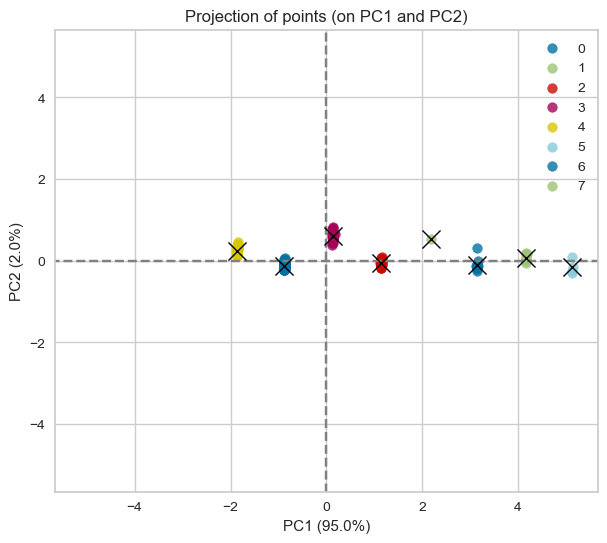

In [98]:
from sklearn.decomposition import PCA
centres_reduced = pca.transform(kmeans.cluster_centers_)
display_factorial_planes(pca_fit, 2, pca, [(0,1)], illustrative_var = clusters, alpha = 0.8)
plt.scatter(centres_reduced[:, 0], centres_reduced[:, 1],
            marker='x', s=169, linewidths=1,
            color='black', zorder=10);

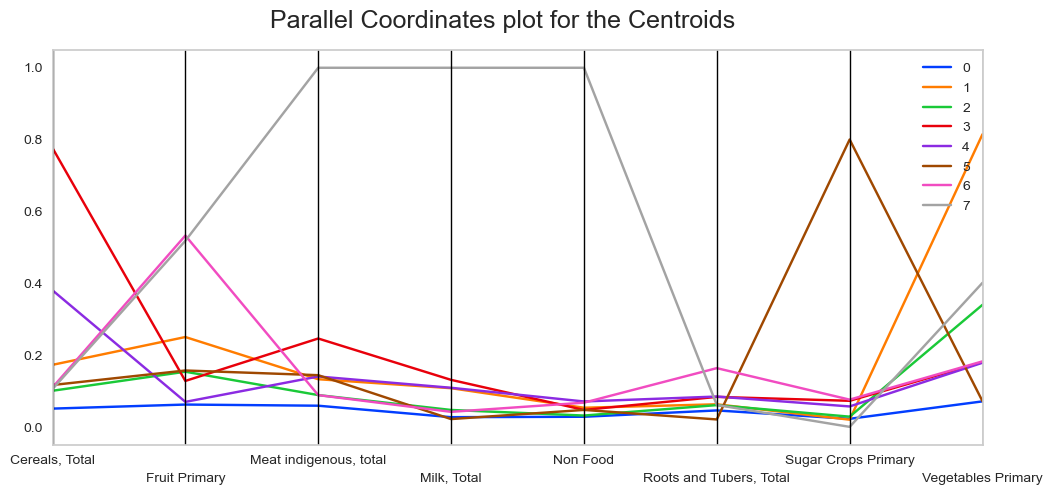

In [100]:
from pandas.plotting import parallel_coordinates
palette = sns.color_palette("bright", 10)


# Add the cluster number to the original scaled data
X_clustered = pd.DataFrame(data_scaled, index=data_scaled.index, columns=data_scaled.columns)
X_clustered["cluster"] = clusters
means =  X_clustered.groupby(by="cluster").mean()
display_parallel_coordinates_centroids(means.reset_index(), 5)

In [103]:
def get_redundant_pairs(df):
    pairs_to_drop = set()
    cols = df.columns
    for i in range(0, df.shape[1]):
        for j in range(0, i+1):
            pairs_to_drop.add((cols[i], cols[j]))
    return pairs_to_drop

def get_top_abs_correlations(df, n=5):
    au_corr = df.corr().abs().unstack()
    labels_to_drop = get_redundant_pairs(df)
    au_corr = au_corr.drop(labels=labels_to_drop).sort_values(ascending=False)
    return au_corr[0:n]

print("Top Absolute Correlations")
print(get_top_abs_correlations(data_scaled, 5))

Top Absolute Correlations
Item                    Item       
Meat indigenous, total  Milk, Total    0.790195
Fruit Primary           cluster        0.545254
Cereals, Total          cluster        0.479992
Milk, Total             Non Food       0.477975
Meat indigenous, total  Non Food       0.477293
dtype: float64


In [104]:
codes_df = pd.read_csv(pop_folder /"Population_E_AreaCodes.csv", encoding = 'unicode_escape')

In [105]:
prod19_df=prod19_df.merge(codes_df, on='Area')

In [106]:
import country_converter as coco
cc = coco.CountryConverter()
prod19_df['iso']=cc.pandas_convert(prod19_df['Area'], to='ISO3')

In [107]:
pd.set_option('display.max_rows', None)

In [108]:
import plotly.express as px

In [109]:
fig = px.choropleth(prod19_df, 
                    locations=prod19_df['iso'], 
                    color="cluster_no",
                     hover_name="cluster_no",
                    labels={'cluster_no':'Cluster'},
                    title='foo',
                    color_continuous_scale=px.colors.sequential.Plasma,
                   )
fig.update_geos(fitbounds="locations", visible=True)
fig.update_layout(title_text='Map of countries by cluster',title_x = 0.4, title_y=0.9,margin={"r":0,"t":0,"l":0,"b":0})
fig.show()

In [110]:

cluster_ire=prod19_df['cluster_no'][prod19_df['Area']=='Ireland'].values[0]
print("Regions in the same cluster than Ireland: \n")
#use to_string function to remove the "Name", "Dtype" from the output. 
print(prod19_df['Area'][prod19_df['cluster_no']==cluster_ire].to_string(index=False))

Regions in the same cluster than Ireland: 

                         Austria
                      Bangladesh
                         Belarus
                         Croatia
                         Czechia
                         Finland
                         Germany
                          Guinea
                         Ireland
                      Kazakhstan
Lao People's Democratic Republic
                            Mali
                         Myanmar
                           Nepal
                          Poland
              Russian Federation
                        Slovakia
                        Suriname
                          Sweden
                        Thailand
                        Viet Nam


In [111]:
prod19_df[prod19_df['cluster_no']==cluster_ire]

Area  Cereals, Total  Fruit Primary  \
8                             Austria      129.367090      51.851814   
12                         Bangladesh      134.773630      14.964878   
14                            Belarus      156.858130      37.247579   
40                            Croatia      176.956147      43.789797   
43                            Czechia      161.736440      12.421429   
60                            Finland      146.348924       7.382727   
66                            Germany      118.468950      22.799620   
71                             Guinea      129.679669      43.431125   
82                            Ireland       94.283744       4.168693   
88                         Kazakhstan      215.732022      50.821739   
93   Lao People's Democratic Republic      213.745101      62.533650   
105                              Mali      142.969630      42.538190   
115                           Myanmar      203.248980      20.601426   
117                             Nepal      114.641757      24.135129   
135                            Poland      162.649943      69.125022   
142                Russian Federation      182.018416      28.566562   
155                          Slovakia      163.658680      11.266200   
164                          Suriname      178.720342      62.735195   
165                            Sweden      130.851013       3.920657   
169                          Thailand      171.443143      69.294461   
188                          Viet Nam      187.528073      44.214963   

     Meat indigenous, total  Milk, Total   Non Food  Roots and Tubers, Total  \
8                244.388476   179.420920   1.280076                21.173229   
12                16.057212     9.966002   7.549592                14.893519   
14               312.594900   318.123964   9.408132               157.946101   
40               124.603124    62.397209   4.544099                10.493124   
43               104.916441   125.320221   0.075354                14.787882   
60               179.401859   178.952708   0.155210                28.052334   
66               195.163185   165.699952   1.027203                31.911754   
71                47.321154     9.391701  11.073933                38.969868   
82               791.689942   700.796913  11.969521                19.545472   
88               214.422133   130.310514  35.183477                52.205638   
93                68.752961     0.421239  85.793601               151.882966   
105               25.199510    24.719916   0.312387                 8.149295   
115              152.540944    20.328312  12.798195                 3.610694   
117               48.794943    39.438521   2.252493                28.221247   
135              249.700983   156.894856   4.038723                42.140744   
142              174.316224    89.611007   3.951358                37.907035   
155               49.792956    70.268856   0.077559                 8.370854   
164               56.664906     2.218887   0.021656                 2.820252   
165              138.361686   109.606988   0.497666                20.642249   
169               83.530737     7.003193  91.674843                65.098634   
188              107.855379     4.437446  58.714448                19.396290   

     Sugar Crops Primary  Vegetables Primary  cluster_no  Area Code M49 Code  \
8              10.425859           23.984622           4         11     '040   
12              0.906715           14.477892           4         16     '050   
14             24.083285           67.084551           4         57     '112   
40              8.083294           12.333186           4         98     '191   
43             16.370515            6.474598           4        167     '203   
60              4.278157           17.558155           4         67     '246   
66             16.843900           16.112603           4         79     '276   
71              1.094308           16.459667   

In [124]:
prod_df.head()

Area               Item  Year  Total_Prod
0  Afghanistan  Almonds, in shell  1961         NaN
1  Afghanistan  Almonds, in shell  1962         NaN
2  Afghanistan  Almonds, in shell  1963         NaN
3  Afghanistan  Almonds, in shell  1964         NaN
4  Afghanistan  Almonds, in shell  1965         NaN

In [123]:
#prod_wide=pd.wide_to_long(prod_df, stubnames='Y', i=['Area', 'Item'], j='Year').reset_index()

ValueError: the id variables need to uniquely identify each row

In [125]:
prod_wide=prod_df

In [132]:
prod_wide = prod_wide[prod_wide["Area"].isin(prod19_df["Area"][prod19_df['cluster_no']==cluster_ire].unique())]

In [133]:
prod_wide = prod_wide[prod_wide["Item"].isin(['Apples', 'Hen eggs in shell, fresh', 'Meat indigenous, total', 'Milk, Total'])]

In [134]:
#create_report(prod_wide).show_browser()

In [135]:
#STREAMLIT APP

for item in prod_wide['Item'].unique():
    fig = plt.figure(figsize=(8,7))
    plt.title(item)
    sns.lineplot(data=prod_wide[prod_wide['Item']==item].drop('Item', axis=1), x='Year', y='Y', hue='Area')
    st.pyplot(fig)

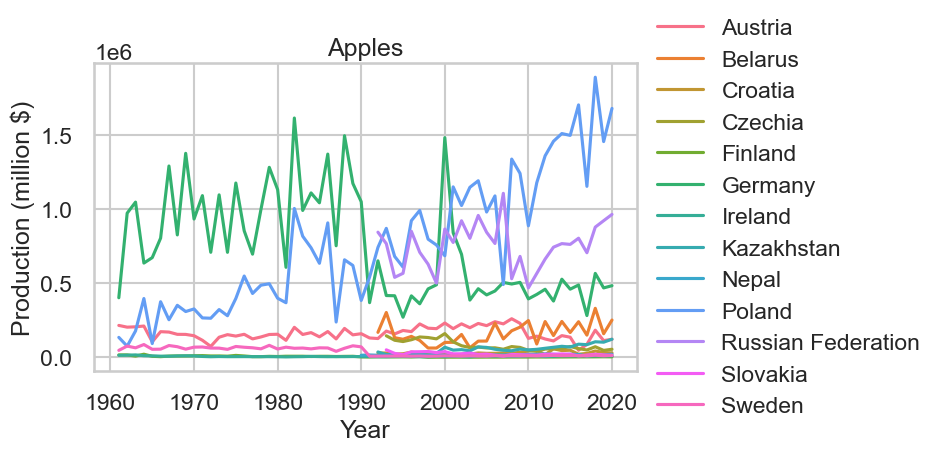

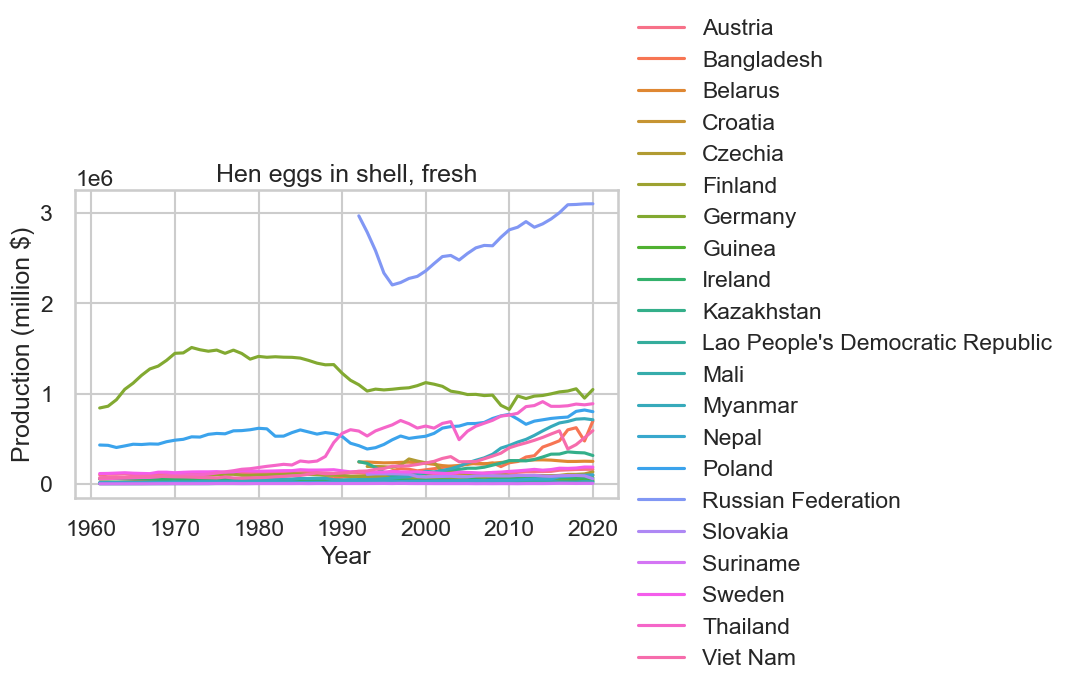

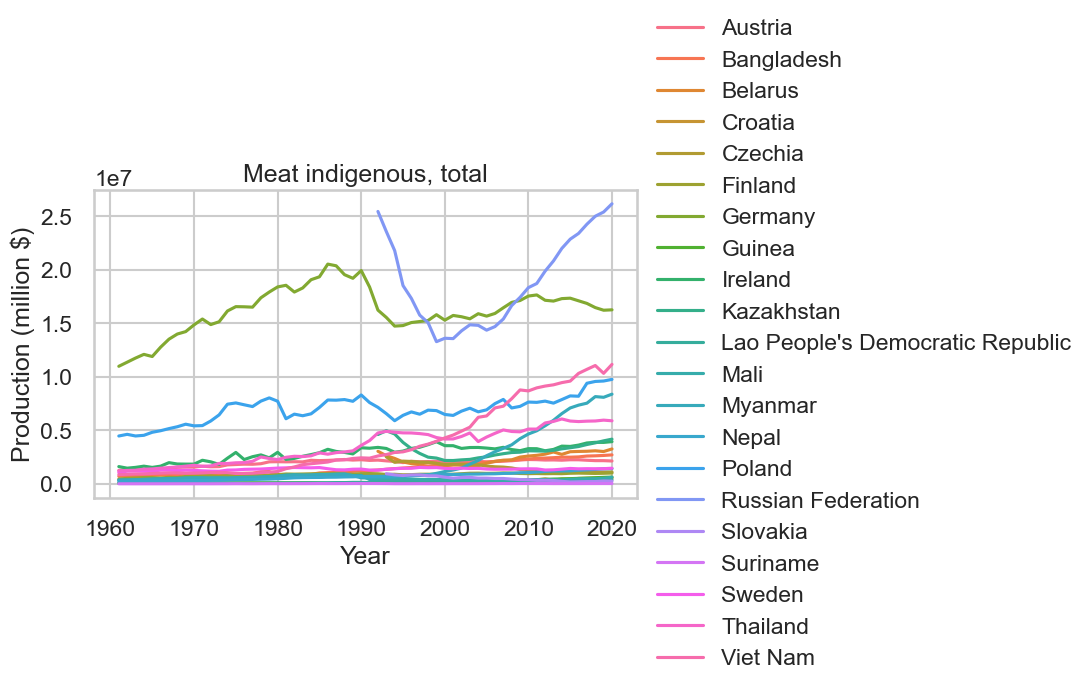

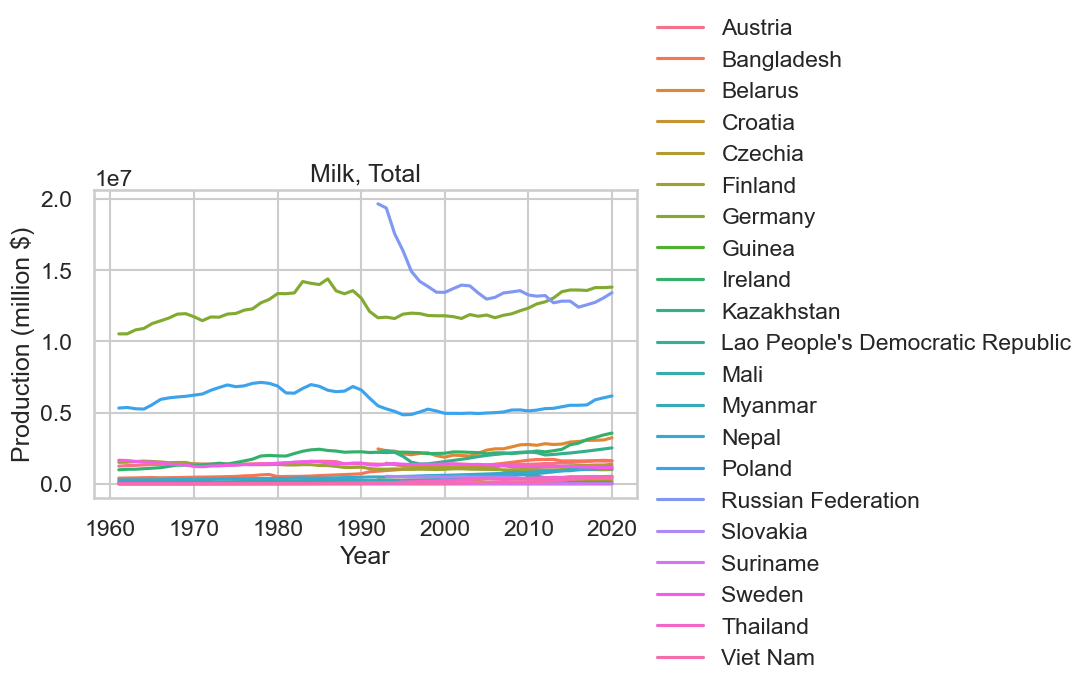

In [136]:
for item in prod_wide['Item'].unique():
    fig = plt.figure(figsize=(7,4))
    ax = plt.subplot(111)
    plt.title(item)
    sns.lineplot(data=prod_wide[prod_wide['Item']==item].drop('Item', axis=1), x='Year', y='Total_Prod', hue='Area')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    ax.set_ylabel('Production (million $)')
    plt.show(fig)

In [137]:
prod_wide

Area                      Item  Year  \
37620                            Austria                    Apples  1961   
37621                            Austria                    Apples  1962   
37622                            Austria                    Apples  1963   
37623                            Austria                    Apples  1964   
37624                            Austria                    Apples  1965   
37625                            Austria                    Apples  1966   
37626                            Austria                    Apples  1967   
37627                            Austria                    Apples  1968   
37628                            Austria                    Apples  1969   
37629                            Austria                    Apples  1970   
37630                            Austria                    Apples  1971   
37631                            Austria                    Apples  1972   
37632                            Austria                    Apples  1973   
37633                            Austria                    Apples  1974   
37634                            Austria                    Apples  1975   
37635                            Austria                    Apples  1976   
37636                            Austria                    Apples  1977   
37637                            Austria                    Apples  1978   
37638                            Austria                    Apples  1979   
37639                            Austria                    Apples  1980   
37640                            Austria                    Apples  1981   
37641                            Austria                    Apples  1982   
37642                            Austria                    Apples  1983   
37643                            Austria                    Apples  1984   
37644                            Austria                    Apples  1985   
37645                            Austria                    Apples  1986   
37646                            Austria                    Apples  1987   
37647                            Austria                    Apples  1988   
37648                            Austria                    Apples  1989   
37649                            Austria                    Apples  1990   
37650                            Austria                    Apples  1991   
37651                            Austria                    Apples  1992   
37652                            Austria                    Apples  1993   
37653                            Austria                    Apples  1994   
37654                            Austria                    Apples  1995   
37655                            Austria                    Apples  1996   
37656                            Austria                    Apples  1997   
37657                            Austria                    Apples  1998   
37658                            Austria                    Apples  1999   
37659                            Austria                    Apples  2000   
37660                            Austria                    Apples  2001   
37661                            Austria                    Apples  2002   
37662                            Austria                    Apples  2003   
37663                            Austria                    Apples  2004   
37664                            Austria                    Apples  2005   
37665                            Austria                    Apples  2006   
37666                            Austria                    Apples  2007   
37667                            Austria                    Apples  2008   
37668                            Austria                    Apples  2009   
37669                            Austria                    Apples  2010   
37670                            Austria                    Apples  2011   
37671                            Austria                    Apples  2012   
37672   